FGKcupid with period as the dependent variable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import george
from george.kernels import ExpSquaredKernel, WhiteKernel
import pandas as pd
import emcee
from MCMC_plots import make_plot
import time
import h5py
import os
from teff_bv import teff2bv
import barnes as bn

RESULTS_DIR = "results"
DATA_DIR = "data"

/Users/ruthangus/projects/fgkcupid/dev/teff_bv.py:16: RuntimeWarning: invalid value encountered in log10
  + d1*feh*np.log10(teff) + g1*logg + e1*logg*np.log10(teff)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in less
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in less
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


(array([  6.25000000e-01,   6.25000000e-01,   6.25000000e-01,
          6.25000000e-01,   6.25000000e-01,   6.25000000e-01,
          6.25000000e-01,   6.25000000e-01,   6.25000000e-01,
          6.25000000e-01,   6.25000000e-01,   6.25000000e-01,
          6.25000000e-01,   6.25000000e-01,   6.25000000e-01,
          6.25000000e-01,   6.25000000e-01,   6.25000000e-01,
          6.25000000e-01,   6.25000000e-01,   6.25000000e-01,
          6.25000000e-01,   5.88000000e-01,   5.88000000e-01,
          5.88000000e-01,   5.88000000e-01,   5.88000000e-01,
          5.88000000e-01,   5.88000000e-01,   5.88000000e-01,
          5.88000000e-01,   5.88000000e-01,   5.88000000e-01,
          5.88000000e-01,   5.88000000e-01,   5.88000000e-01,
          5.88000000e-01,   5.88000000e-01,   5.88000000e-01,
          5.88000000e-01,   5.88000000e-01,   5.88000000e-01,
          5.88000000e-01,   5.88000000e-01,   5.88000000e-01,
          5.88000000e-01,   5.88000000e-01,   5.88000000e-01,
        

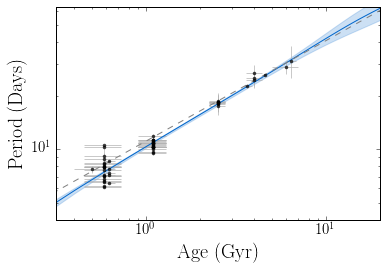

In [8]:
# plot model
def log_period_model(par, log_a, bv):
    return np.log10(par[0]) + par[1] * log_a + par[2] * np.log10(bv - par[3])

def period_model(par, a, bv):
    log_a = np.log10(a*1000)
    return 10**(np.log10(par[0]) + par[1] * log_a + par[2] * np.log10(bv - par[3]))

def load_original_data():
    # load data
    bv, bv_err, p, p_err, a, a_err, logg, logg_err, f = \
        np.genfromtxt("data/clusters.txt").T

    # load 16Cyg A
    bv16, bv_err16, p16, perr16, a16, aerr16, _, _, _, _ = \
        np.genfromtxt("data/16CygA.txt").T

    # load NGC6819
    bv19s, p19s = np.genfromtxt("data/NGC6819.txt", skip_header=1).T
    a19s = np.ones_like(p19s)*2.5
    
    # add M67 (rebecca + barnes)
    epic, bv67, v, p67, perr67 = np.genfromtxt("data/barnes_M67.txt", skip_header=1).T
    #epic, p67, bv67, bv_067, _ = np.genfromtxt("data/acf_ls_results.txt", skip_header=1,
    #                                     delimiter=",").T
    a67 = np.ones_like(p67) * 4
    
    # load astero
    data = np.genfromtxt("data/garcia_irfm.txt").T
    p1, p_err1 = data[6], data[7]
    t1, t_err1 = data[1], data[2]
    a1, a_err1 = data[3], .5 * (data[4] + data[5])
    logg1, logg_err1 = data[8], .5 * (data[9] + data[10])
    feh1, feh_err1 = data[11], data[12]
    flag1 = data[13]
    bv1 = teff2bv(t1, logg1, feh1)
    df = pd.DataFrame(data, columns=["kepid", "teff", "teff_err", "age", "age_errp", "age_errm", "period", 
                                     "period_err", "logg", "logg_errp", "logg_errm", "feh", "feh_err", "flag"])
    df.to_csv("data/garcia_irfm.csv")
    m1 = logg1 > 4
    
    bv = np.concatenate((bv, bv16, bv19s, bv67, bv1[m1]))
    bv_err = np.concatenate((bv_err, bv_err16, np.ones_like(bv19s)*.01, np.ones_like(bv67)*.01, 
                            np.ones_like(bv1[m1])*.01))
    p = np.concatenate((p, p16, p19s, p67, p1[m1]))
    p_err = np.concatenate((p_err, perr16, p19s*.1, p67*.1, p_err1[m1]))
    a = np.concatenate((a, a16, a19s, a67, a1[m1]))
    a_err = np.concatenate((a_err, aerr16, a19s*.1, a67*.1, a_err1[m1]))
    
    # select based on colour
    m = (.6 < bv) * (bv < .7) * (p > 5) * (a/p < 1)
    ma = (.6 < bv1) * (bv1 < .7) * (logg1 > 4) * (a1/p1 < 1)
    
    pars = [.407, .566, .325, .495]  # MH
    xp = np.linspace(0, 20, 100)
    
    A, lbv, lp, sigma = 10, 2000, 10, 1.
    x, y, xerr, yerr = a[m], p[m], a_err[m], p_err[m]
    k = A**2 * ExpSquaredKernel(lp**2)
    gp = george.GP(k)
    gp.compute(x, (yerr**2+sigma**2)**.5)
    
    mod1 = period_model(pars, x, .65)
    
    mus, covs = gp.predict(y - mod1, xp)
    vs = np.diag(covs)**.5
    
    mod2 = period_model(pars, xp, .65)
    
    plt.plot(xp, mus+mod2, color='#0066CC')
    plt.fill_between(xp, mus-vs+mod2, mus+vs+mod2, alpha=.2, color='#0066CC')

    plt.plot(xp, mod2, '.5', ls="--")
    plt.errorbar(a[m], p[m], xerr=a_err[m], yerr=p_err[m], fmt="k.", capsize=0, ecolor=".7", alpha=.7)

    plt.xlim(10**-.5, 10**1.3)
    plt.ylim(10**.6, 10**1.8)
    plt.xlabel("$\mathrm{Age~(Gyr)}$")
    plt.ylabel("$\mathrm{Period~(Days)}$")
    plt.loglog()
    plt.subplots_adjust(left=.15, bottom=.16)
    plt.savefig("fgkcupid_demo.pdf")
    return a, a_err, p, p_err, bv, bv_err

load_original_data()

Flip axes

In [3]:
A, lbv, lp, sigma = 10, 2000, 10, 1.
theta_init = np.log(np.array([A, lbv, lp, sigma]))  # initial guess

In [12]:
def lnprior(theta):  # very broad uniform log prior
    if -20 < theta[0] < 20 and 0 < theta[1] < 20 and 0 < theta[2] < 20 and -20 < theta[3] < 20:
        return 0.
    return -np.inf

In [13]:
def lnlike(theta, x, y, z, yerr, mean_model=True):
    theta = np.exp(theta)
    D = np.vstack((x, z)).T
    k = theta[0]**2 * ExpSquaredKernel([theta[1]**2, theta[2]**2], ndim=2)
    gp = george.GP(k)
    try:
        gp.compute(D, (yerr**2 + theta[3]**2)**.5)
    except (ValueError, np.linalg.LinAlgError):
        return 10e25
    if mean_model:
        r = y - bn.age(z, x)
        m = np.isfinite(r)
        if len(r) > len(r[m]):
            return -np.inf
        return gp.lnlikelihood(r, quiet=True)
    return gp.lnlikelihood(y, quiet=True)

In [14]:
def lnprob(theta, x, y, z, yerr):
    return lnlike(theta, x, y, z, yerr) + lnprior(theta)

/Users/ruthangus/projects/fgkcupid/dev/teff_bv.py:16: RuntimeWarning: invalid value encountered in log10
  + d1*feh*np.log10(teff) + g1*logg + e1*logg*np.log10(teff)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in less
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in less
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


NameError: name 'period' is not defined

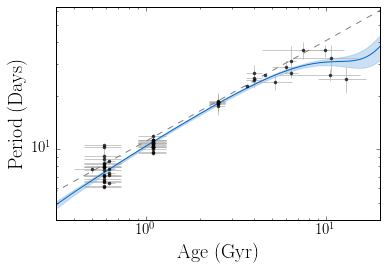

In [19]:
age, age_err, period, period_err, bv, bv_err = load_original_data()
x, y, z, yerr = bv, period, age, period_err
burnin, nwalkers, ndim = 1000, 24, len(theta_init)
runs = np.zeros(5) + 1000
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (x, y, z, yerr)